## ECON 323 Final Project
### An Analysis of Airbnb Prices Across Popular Countries in Europe


Karina Grewal (section 004), Hrithik Soni (section 003)

## Introduction

### Reading data

In [52]:
#loading necessary packages
#!pip install opendatasets
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import glob, os
import seaborn as sns
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [4]:
#downloading datasets to a local folder
od.download("https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities")

Skipping, found downloaded files in "./airbnb-prices-in-european-cities" (use force=True to force download)


In [5]:
#accessing one dataset to take a peek at the data
amsterdam_weekdays = pd.read_csv('airbnb-prices-in-european-cities/amsterdam_weekdays.csv', index_col=0)
amsterdam_weekdays.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508


In [6]:
#trying to download all datasets
path = r'airbnb-prices-in-european-cities' 

# Get the files from the path provided in the OP
files = Path(path).glob('*.csv')  # .rglob to get subdirectories
dfs = list()

#appending all the different files into dataframes by filename of form city_time
for i, f in enumerate(files):
    data = pd.read_csv(f, index_col=0).assign(City=os.path.basename(f).split('.')[0])
    dfs.append(data)

#Combining into a single dataframe
df = pd.concat(dfs, ignore_index=True)

#splitting the file name into two columns with city name and weekday/weekend time period separate
df[['city', 'time']] = df.City.str.split("_", expand = True)
df = df.drop('City', axis=1)

#preview
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,time
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,weekdays


### EDA

#### Plot #1

In [7]:
#Creating coordinates for geopandas to read
df["Coordinates"] = list(zip(df.lng, df.lat))
df["Coordinates"] = df["Coordinates"].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,time,Coordinates
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,weekdays,POINT (4.90569 52.41772)
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,weekdays,POINT (4.90005 52.37432)
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,weekdays,POINT (4.97512 52.36103)
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,weekdays,POINT (4.89417 52.37663)
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,weekdays,POINT (4.90051 52.37508)


In [8]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

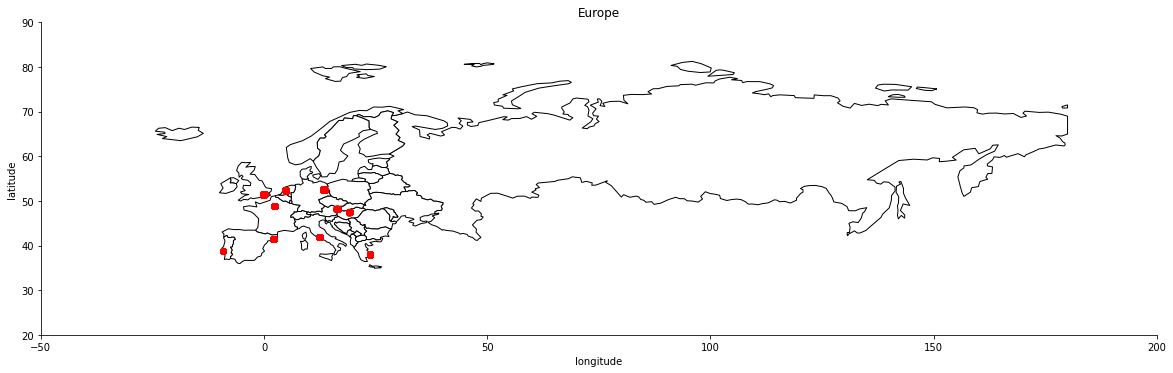

In [9]:
# Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(20,20))

# By only plotting rows in which the continent is 'Europe' we only plot, well,
# South America.
world.query("continent == 'Europe'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Europe')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.xlim(-50, 200)
plt.ylim(20, 90)

# Plotting the city names
# for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['city']):
#     gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')
    
plt.show()

### Plot #2

(0.0, 11000.0)

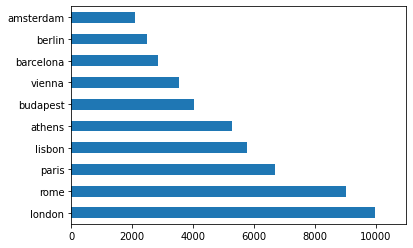

In [10]:
df["city"].value_counts().plot(kind = "barh")

plt.xlim(0, 11000)

### Plot #3: Price vs distance to city

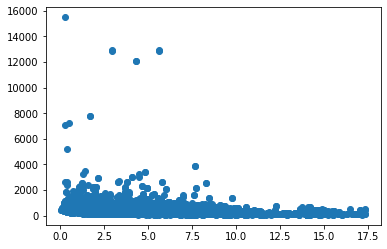

In [11]:
fig, ax = plt.subplots()

ams_rs = df.loc[df["city"] == "london"]["realSum"]
ams_cr = df.loc[df["city"] == "london"]["dist"]

ax.scatter(ams_cr, ams_rs)


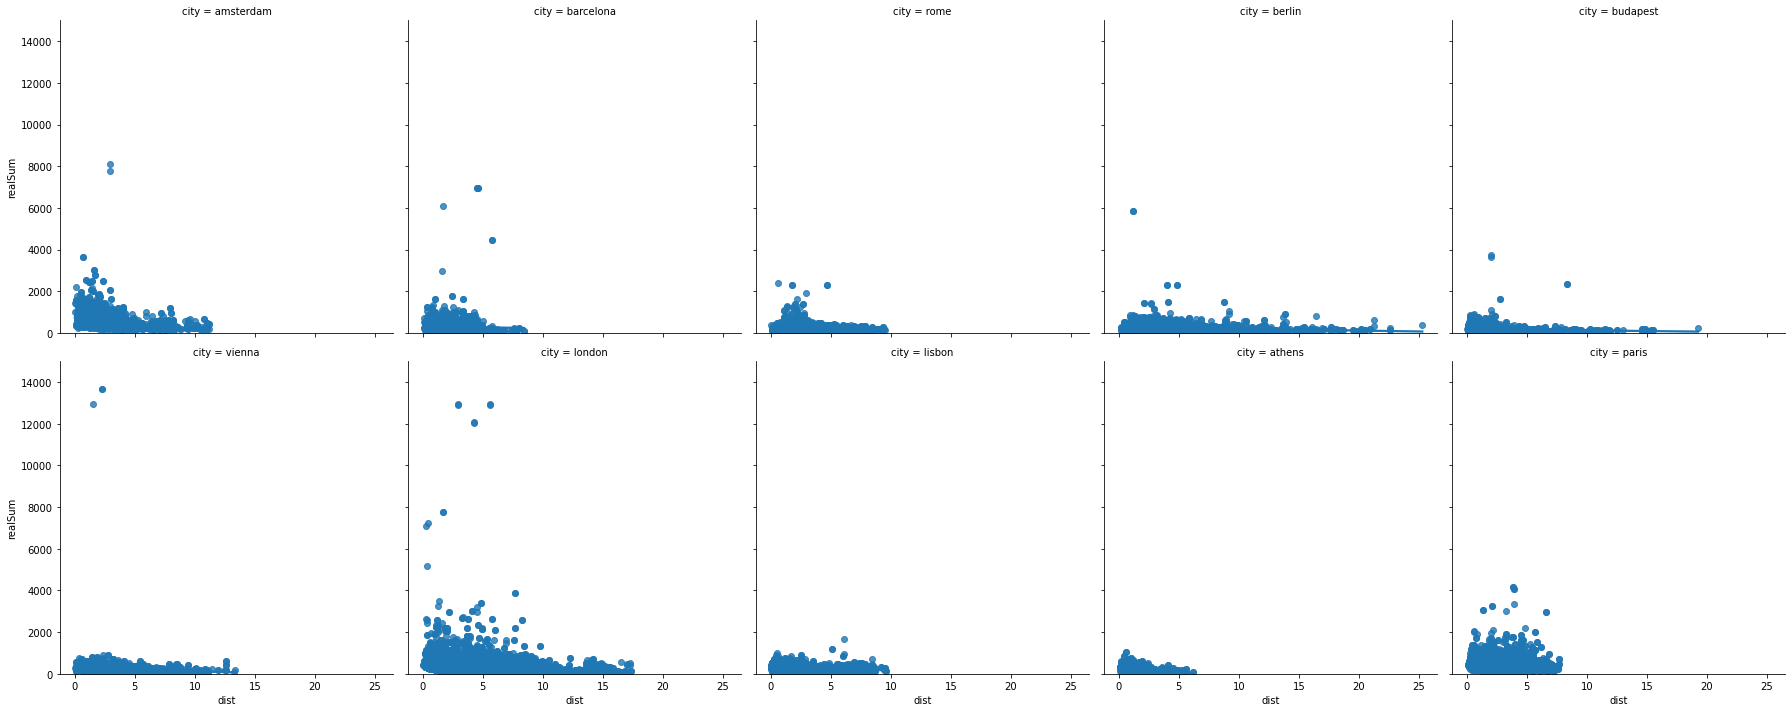

In [12]:
x = sns.lmplot(data=df, x='dist', y = 'realSum', col='city', col_wrap=5)
x.set(ylim = (0, 15000))

### Plot #4: Average price per city

<AxesSubplot: xlabel='city'>

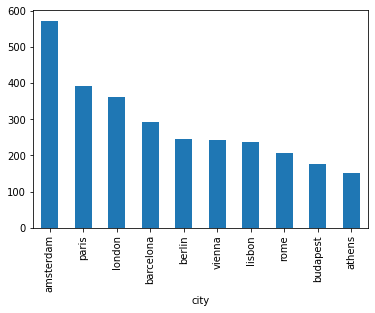

In [13]:
avg_price = df.groupby("city")["realSum"].mean()

avg_price.sort_values(ascending=False).plot.bar()

### Plot #5: Correlation heat map

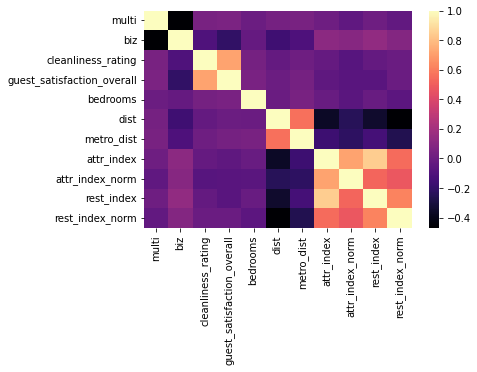

In [14]:
# Heatmap
df_heatmap = df.select_dtypes(include=np.number).iloc[:,2:-2]
df_heatmap

sns.heatmap(df_heatmap.corr(), annot = False, cmap = 'magma')
plt.show()

### Plot #6: Distribution Plot

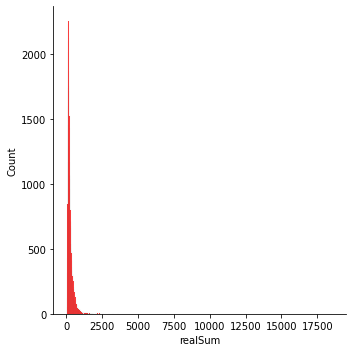

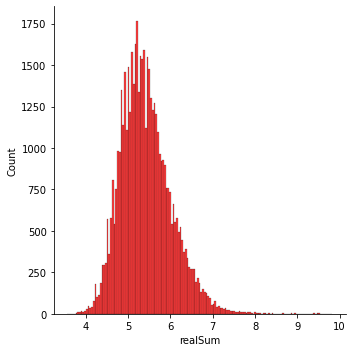

In [15]:
y = sns.displot(df['realSum'], color = 'r')

sns.displot(np.log(df['realSum']), color = 'r')

## Methods

### Prediction

#### 1. Full OLS

In [103]:
x = df.drop(["Coordinates", "realSum", "city", "attr_index", "rest_index"], axis=1)
X = pd.get_dummies(data=x, drop_first=True)
X["host_is_superhost"] = X["host_is_superhost"].astype(int)
X = X.drop(["room_shared", "room_private", "person_capacity"], axis = 1)
Y = np.log(df["realSum"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25)

airbnb_ols = linear_model.LinearRegression()
airbnb_ols.fit(X, Y)

# airbnb_ols = sm.OLS(y_train, x_train).fit()

# #view model summary
# print(airbnb_ols.summary())

LinearRegression()

In [104]:
new_mse = metrics.mean_squared_error(y_test, airbnb_ols.predict(x_test))
new_mse

0.15389629781435132

#### 2. Forward/Backward selection

#### 3. Lasso Regression

In [108]:
# LassoCV exploits special structure of lasso problem to minimize CV more efficiently
lasso = linear_model.LassoCV(cv=5).fit(x_train,y_train)
-np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

lasso_model = linear_model.Lasso()
lasso_model.fit(X, y)

lasso_coefs = pd.Series(dict(zip(list(x_train), lasso_model.coef_)))
lasso_coefs

host_is_superhost              -0.000000
multi                           0.000000
biz                            12.333433
cleanliness_rating              4.542949
guest_satisfaction_overall      0.715684
bedrooms                      114.746542
dist                           -6.485755
metro_dist                     -2.694710
attr_index_norm                 6.435510
rest_index_norm                -0.167045
lng                            -5.177534
lat                            10.992193
room_type_Private room       -124.474086
room_type_Shared room         -46.406685
time_weekends                   0.000000
dtype: float64

#### 4. Ridge Regression

In [ ]:
5. Elastic 

1. Forward/Backward selection
2. Ridge/Lasso/Elastic Net Regression
3. Classification: Random forests (Evaluate using ROC/AUC)

### Classification

#### 1. Random Forest

#### 2. LDA